In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


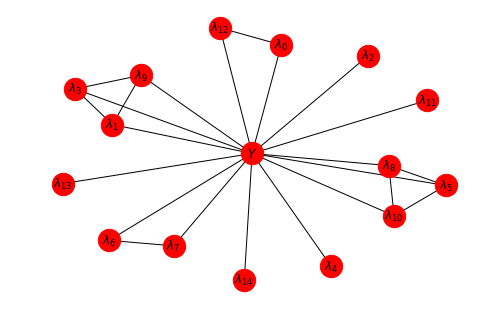

In [2]:
M = 15
N_CLUSTERS = 10
deps_graph = ClusterDependencies(M, N_CLUSTERS)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

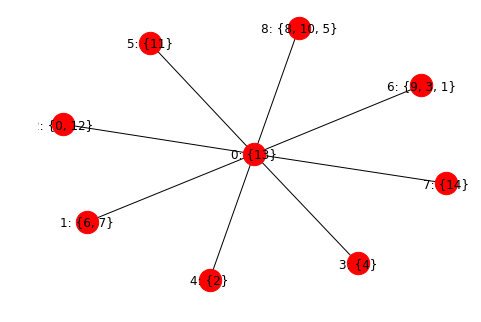

In [3]:
N = 1000 # Not used yet...
K = 2
data = DataGenerator(N, M, k=K, abstains=False, deps_graph=deps_graph)
data.jt.draw()

### Computing entries across cliques

Say we want to compute marginals involving neighboring cliques $C_1$ and $C_2$; we have:
$$
P(C_1, C_2)
= P(C_1, C_2|S_{1,2}) P(S_{1,2})
= P(C_1|S_{1,2}) P(C_2|S_{1,2}) P(S_{1,2})
= \frac{P(C_1) P(C_2) }{ P(S_{1,2}) }
$$

In [4]:
query = {0:2, 5:1, M:1}

In [5]:
%time data.P_marginal(query)

CPU times: user 5.72 ms, sys: 359 µs, total: 6.08 ms
Wall time: 5.85 ms


0.18867153271137127

In [6]:
%%time
p = data.P_marginal_brute_force(query)
print(p)

0.18867153271137174
CPU times: user 3.05 s, sys: 21.8 ms, total: 3.07 s
Wall time: 3.1 s


In [7]:
data.P_marginal({M:1})

0.5677233250914854

In [8]:
data.P_marginal_brute_force({M:1})

0.5677233250914884

## Trying to recover the clique marginals

We start with:
$$
K_O = \Sigma_O^{-1} + \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$
and set:
$$
ZZ^T = \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$

Let $JJ^T = \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}$; then $Z = \Sigma_O^{-1}\Sigma_{OH}J$.

Now our question is: suppose we've estimated $Z$, how do we recover $\Sigma_{OH}$ (which **note is not $\mu$, but we can recover $\mu$ directly from this given the labeling rates and class balance**).
We start by trying to recover an intermediate quantity:
$$
Q 
= \Sigma_{OH} \Sigma_H^{-1} \Sigma_{OH}^T
= \left( \Sigma_O Z J^{-1} \right) \Sigma_H^{-1}  \left( \Sigma_O Z J^{-1} \right)^T
= \Sigma_O Z J^{-1} \Sigma_H^{-1} J^{-T} Z^T \Sigma_O
= \Sigma_O Z \left( J^T \Sigma_H J \right)^{-1} Z^T \Sigma_O
$$

Now we need to recover $J^T\Sigma_H J$... start by noting that:
$$
\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
=
J^{-T}Z^T\Sigma_O\Sigma_O^{-1}\Sigma_OZJ^{-1}
=
J^{-T}Z^T\Sigma_OZJ^{-1}
$$
and
$$
JJ^T
= \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}
$$
and thus
$$
(JJ^T)^{-1}
= \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
$$
and so
$$
J^T\Sigma_HJ
= I + J^T\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}J
$$

Putting these two expressions together we have:
$$
J^T\Sigma_HJ
= I + Z^T\Sigma_OZ
$$

So finally, we have:
$$
Q 
= \Sigma_O Z \left( I + Z^T\Sigma_OZ \right)^{-1} Z^T \Sigma_O
$$

In [9]:
HIGHER_ORDER = True

In [10]:
%time sigma_O = data.get_sigma_O(higher_order_cliques=HIGHER_ORDER)

CPU times: user 834 ms, sys: 3.68 ms, total: 838 ms
Wall time: 840 ms


In [11]:
np.linalg.cond(sigma_O)

10.97883967594569

In [12]:
class_balance = [data.P_marginal({M:i}) for i in range(1, data.k+1)]
class_balance

[0.5677233250914854, 0.43227667490851457]

In [13]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 298.563
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training
Estimating \mu...
[E:0]	Train Loss: 81.272
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training


In [14]:
sigma_O_inv = np.linalg.inv(data.get_sigma_O(higher_order_cliques=HIGHER_ORDER))

sigma_H = data.P_marginal({M:2})

mu = data.get_mu(higher_order_cliques=HIGHER_ORDER)
mu_x = sigma_H * np.array([data.P_marginal(v) for i, v in data.jt.iter_observed(higher_order_cliques=HIGHER_ORDER)])
sigma_OH = mu - mu_x

sigma_OH

array([ 0.02885386, -0.07005924,  0.05176625,  0.01286689,  0.03207929,
        0.06195075,  0.03277761,  0.01052882,  0.0169713 ,  0.01785225,
        0.04842167,  0.00395275, -0.04277427,  0.03558663, -0.0038189 ,
        0.01899352, -0.01107602, -0.00740486,  0.03697431])

In [17]:
SIGN_FLIP = -1
mu_est = SIGN_FLIP * lm.mu.detach().numpy() + mu_x.reshape([-1,1])

mu = data.get_mu(higher_order_cliques=HIGHER_ORDER)

np.hstack([mu_est, mu.reshape([-1, 1])])

array([[0.29097281, 0.28153202],
       [0.11276275, 0.13568541],
       [0.29391042, 0.27697358],
       [0.20328555, 0.19907561],
       [0.25652527, 0.24602955],
       [0.29249498, 0.27222586],
       [0.21477977, 0.2040552 ],
       [0.23186362, 0.22841867],
       [0.23929375, 0.23374085],
       [0.20066916, 0.19482826],
       [0.31466143, 0.29881884],
       [0.22642935, 0.22513604],
       [0.1239553 , 0.13795029],
       [0.2266038 , 0.21496051],
       [0.26414513, 0.26539465],
       [0.08457031, 0.07835598],
       [0.06452852, 0.0681525 ],
       [0.02451618, 0.02693889],
       [0.11750351, 0.10540614]])

In [18]:
np.mean(np.abs(mu - mu_est.ravel()))

0.009380023698374377